In [8]:
import anndata as ad
import squidpy as sp
import cellcharter as cc #ML
import pandas as pd
import scanpy as sc
import scvi #ML
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything #ML
from pathlib import Path
from skimage.io import imread #ML


import torch #ML
torch.set_float32_matmul_precision("high")

# Dealing with annoying warnings
from anndata._core.aligned_df import ImplicitModificationWarning
import warnings

seed_everything(1337)
scvi.settings.seed = 1337

INFO: Seed set to 1337
Seed set to 1337
INFO: Seed set to 1337
Seed set to 1337


In [3]:
# Info
whatFer = "one" # "one" or  "two"

#Load data
base_folder = Path(f"/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/{whatFer}fer/")
adata_file = base_folder / f"{whatFer}fer.h5ad"
out_figs = base_folder / "figures"

ST_sample = sc.read_h5ad(adata_file)

# Cluster-level characterization

## Proportions

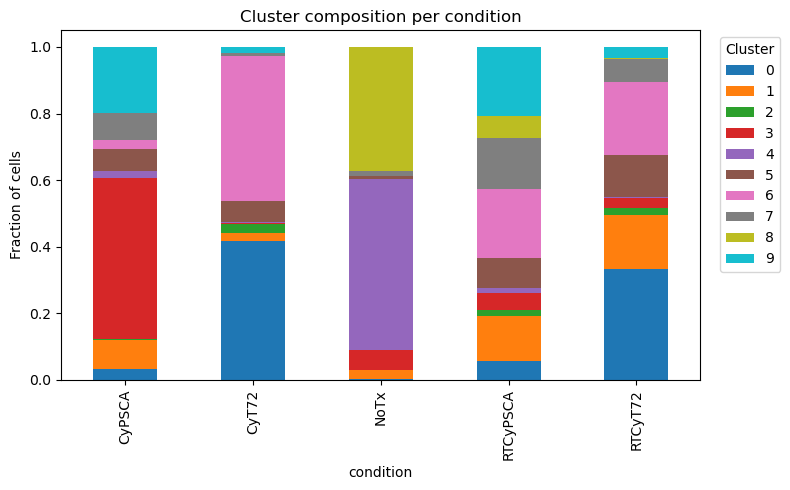

In [3]:
# Count cells per (mouse, cluster)

# What we plotting? mouse, condition, or tumor number
ctgory = "condition"
stack_bar_out = out_figs / f"cluster"

df_counts = (
    ST_sample.obs
    .groupby([ctgory, "cluster_cellcharter"], observed = True)
    .size()
    .reset_index(name="n_cells")
)

# Pivot so that rows = mouse, columns = cluster, values = n_cells
df_pivot = df_counts.pivot(index=ctgory,
                            columns="cluster_cellcharter",
                            values="n_cells").fillna(0)

# Convert counts → fractions (sum over clusters per mouse)
df_frac = df_pivot.divide(df_pivot.sum(axis=1), axis=0)

# Creating plot
fig, ax = plt.subplots(figsize=(8, 5))
df_frac.plot(kind="bar", stacked=True, ax=ax, colormap="tab10")

# Customizing labels and legend
ax.set_ylabel("Fraction of cells")
ax.set_xlabel(ctgory)
ax.set_title(f"Cluster composition per {ctgory}")
ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")

# Layout and saving
prop_fig_out = out_figs / f"cluster_proportion_{ctgory}.png"

plt.tight_layout()
plt.savefig(prop_fig_out, dpi=300)
plt.show()


In [4]:
print(ST_sample.X.dtype)
print(ST_sample.layers.keys())

float64
KeysView(Layers with keys: counts)


# Neighborhood_enrichment

In [5]:
ST_sample.obsp

PairwiseArrays with keys: spatial_connectivities, spatial_distances

In [6]:
cc.gr.nhood_enrichment(
    ST_sample,
    cluster_key="cluster_cellcharter",
    connectivity_key="spatial", #Why does it add _connectivities?!?! weird.
    symmetric=False,         # asymmetric by default (enrichment i→j ≠ j→i)
    only_inter=True,         # count only links between different clusters
    pvalues=True,           # no permutations/p-values (fast, analytical)
    observed_expected=False, # only keep final enrichment, not the raw observed/expected
    copy=False               # write results into ST_sample.uns under "cluster_cellcharter_nhood_enrichment"
    seed = 1337,
    # n_jobs (Optional[int]) – Number of parallel jobs. # TODO can I use this?
)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.89it/s]


In [7]:
ST_sample.obs['condition'].unique()

['RTCyT72', 'RTCyPSCA', 'CyPSCA', 'NoTx', 'CyT72']
Categories (5, object): ['CyPSCA', 'CyT72', 'NoTx', 'RTCyPSCA', 'RTCyT72']

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


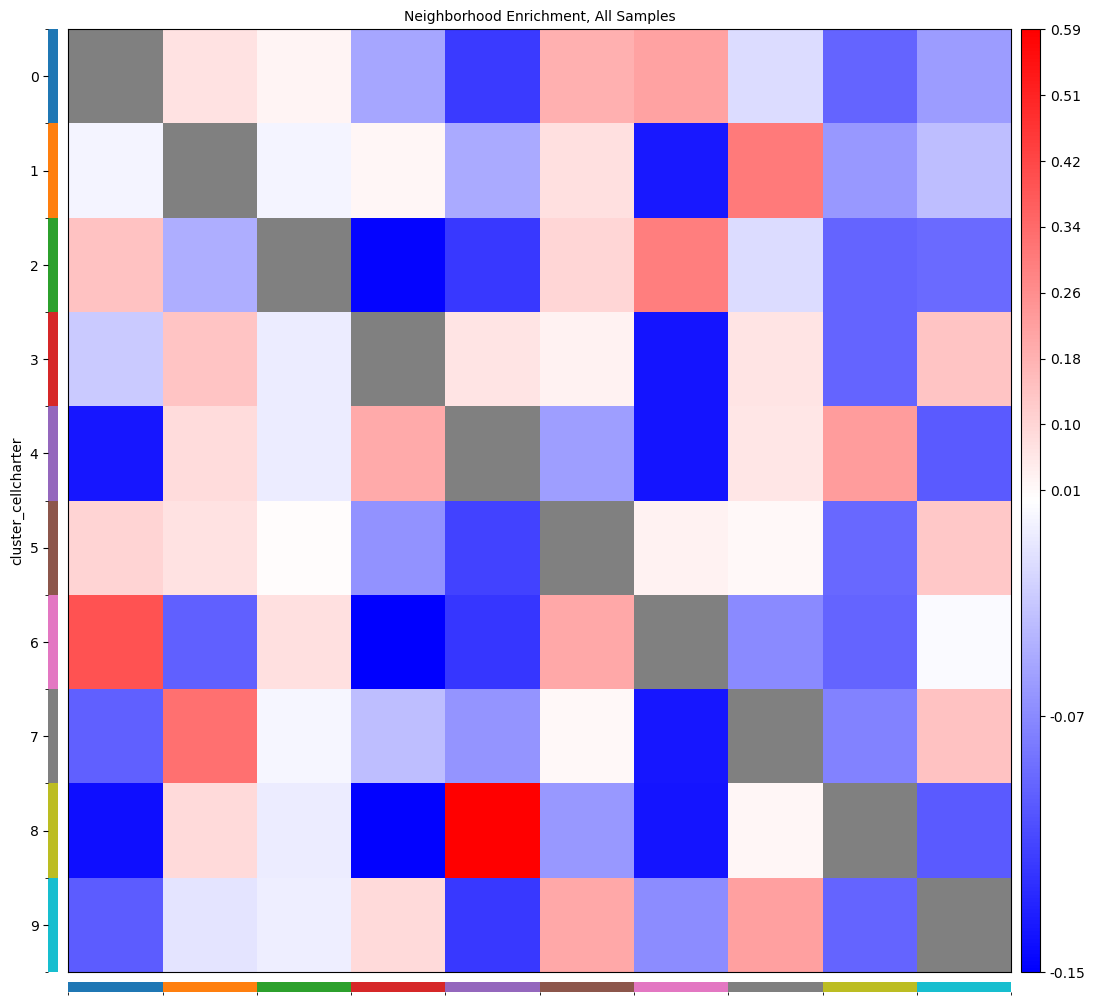

In [22]:
enrich_plot = out_figs / "Neighborhood_enrichment.png"

cc.pl.nhood_enrichment(
    ST_sample,
    cluster_key="cluster_cellcharter",
    title="Neighborhood Enrichment, All Samples",
    palette="tab10",
    save = enrich_plot
    # significance=0.005
)

# Scores typically range from −0.2 to +0.7
# Values near ±0.05 → no strong enrichment or depletion.
# Values > 0.2 or < −0.1 → likely biologically meaningful.

In [9]:

# ignore runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# silence NumPy divide‐by‐zero / invalid warnings - Source is probably from no edges going to certain clusters
old_err = np.seterr(divide="ignore", invalid="ignore")

# Run the enrichment
cc.gr.diff_nhood_enrichment(
    ST_sample,
    cluster_key="cluster_cellcharter",
    condition_key="condition",
    condition_groups=["NoTx", "RTCyT72", "RTCyPSCA", "CyPSCA", "CyT72"],
    pvalues=True,
    copy=False,
)

# Restore NumPy’s old error settings
np.seterr(**old_err)

# Re‐enable warnings if you want
warnings.resetwarnings()

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.19it/s]


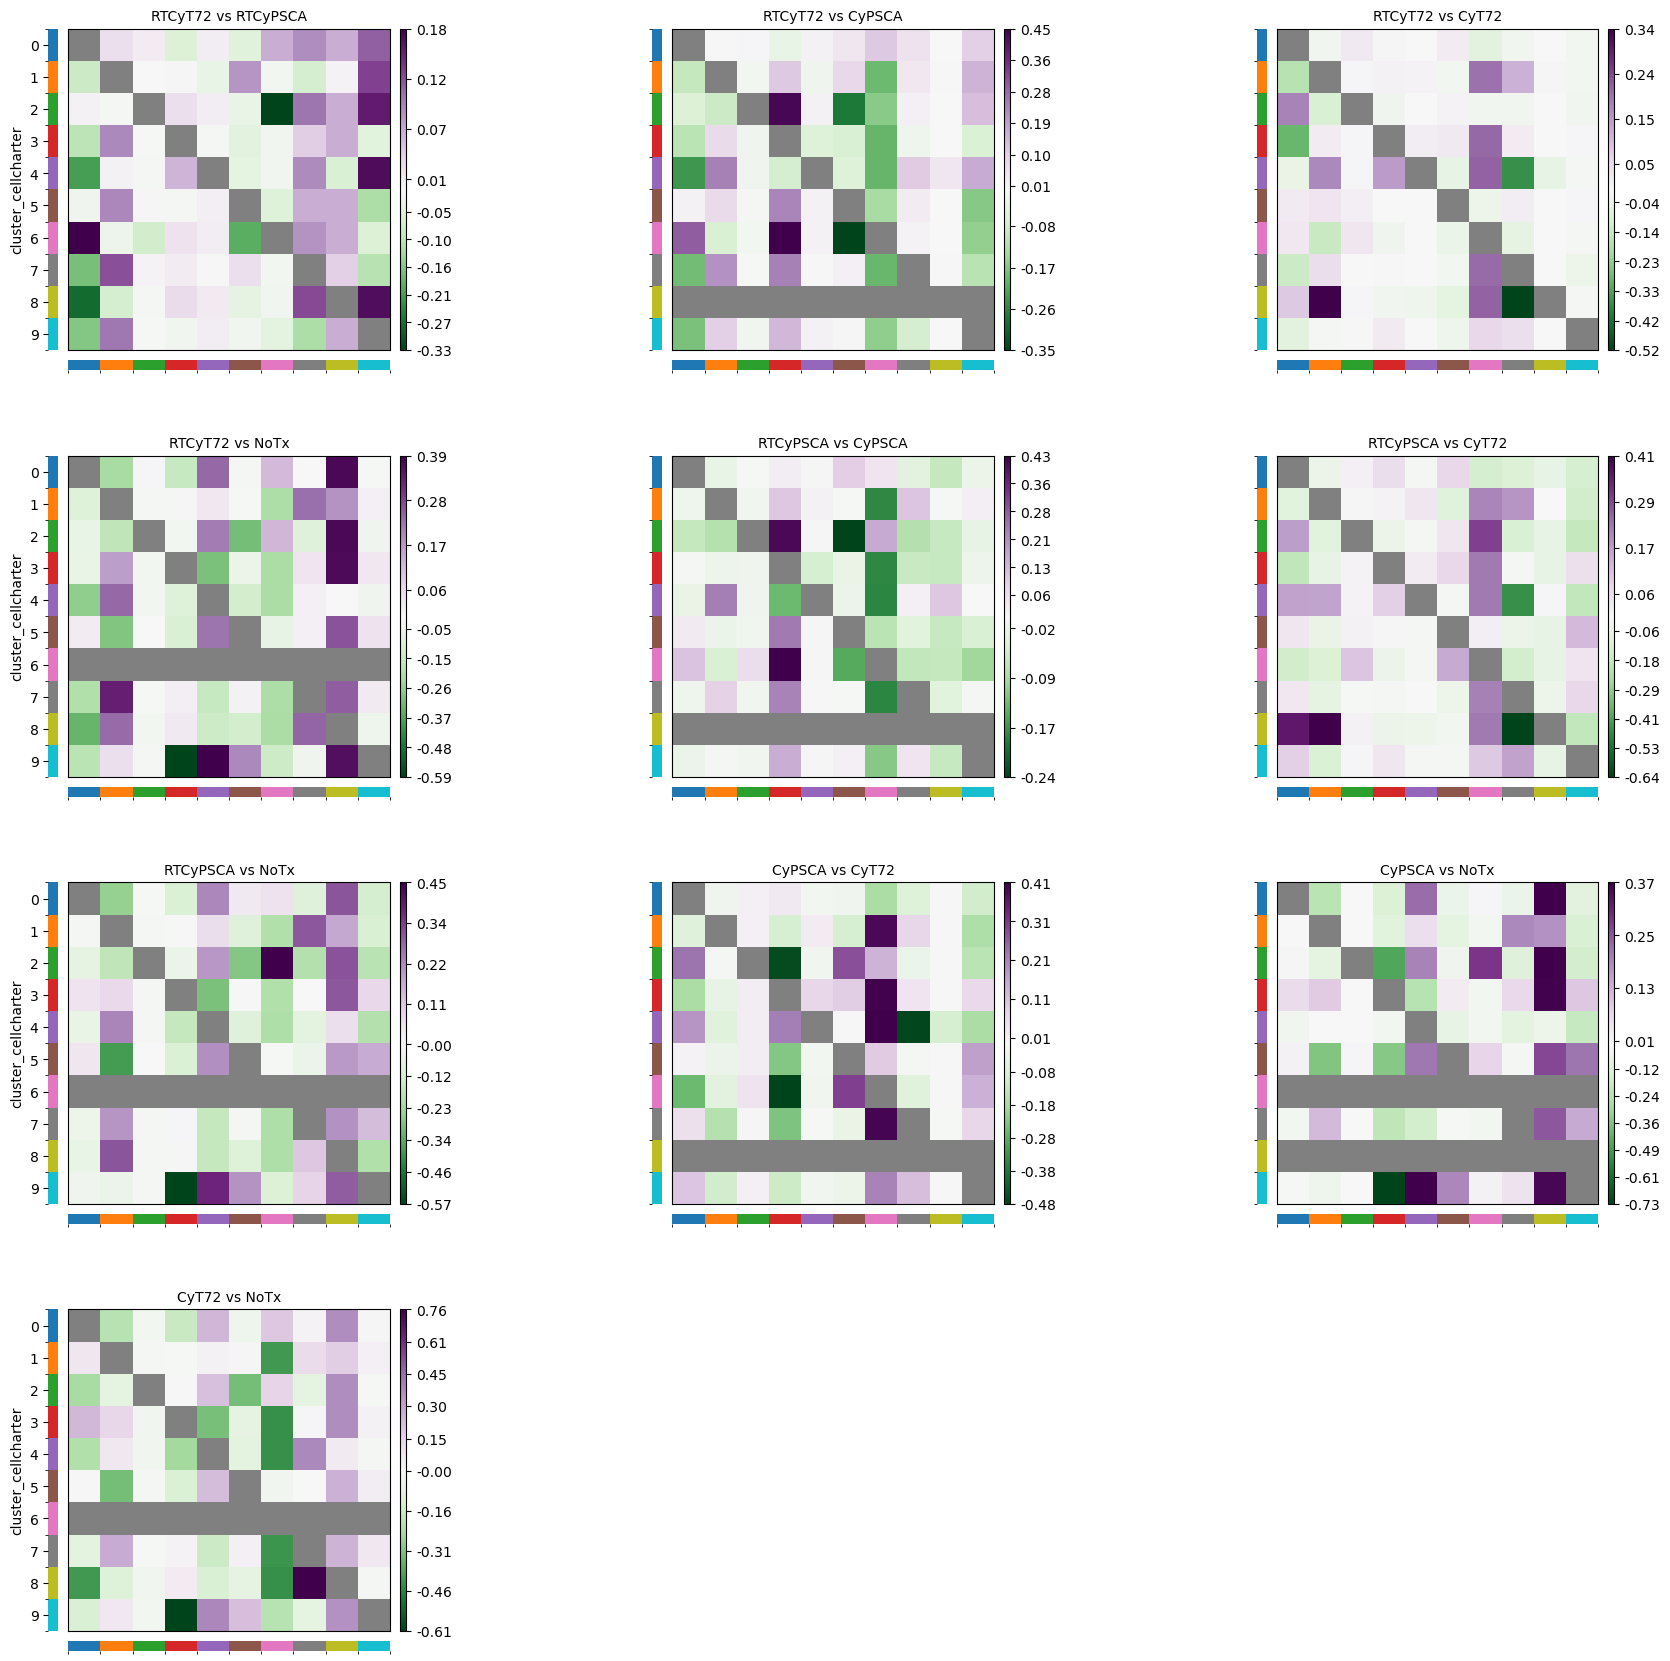

In [23]:
# ignoring "Transforming to str index."
warnings.filterwarnings(
    "ignore",
    message="Transforming to str index.",
    category=ImplicitModificationWarning
)

diff_enrichment = out_figs / "diff_enrichment_plot.png"
cc.pl.diff_nhood_enrichment(
    ST_sample,
    cluster_key="cluster_cellcharter",
    condition_key="condition",
    condition_groups=["RTCyT72", "RTCyPSCA", "CyPSCA", "CyT72", "NoTx"],
    # title=" vs NoTx",
    ncols=3,
    palette="tab10",
    save = diff_enrichment
)

# returning functionality
warnings.filterwarnings("default", category=ImplicitModificationWarning)

In [41]:
ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]


{'NoTx_RTCyT72': {'enrichment':           0         1         2         3         4         5         6  \
  0       NaN  0.228322 -0.006618  0.159566 -0.241232  0.012337 -0.119227   
  1  0.097425       NaN  0.012267 -0.004470 -0.035166  0.007273  0.215893   
  2  0.056526  0.176645       NaN  0.020284 -0.212366  0.311247 -0.125396   
  3  0.052119 -0.164254  0.019248       NaN  0.301001  0.042407  0.219913   
  4  0.265959 -0.240317  0.020463  0.098723       NaN  0.131774  0.220310   
  5 -0.026768  0.290181  0.002293  0.114087 -0.226441       NaN  0.061732   
  6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
  7  0.209246 -0.331082  0.007075 -0.019049  0.156958 -0.013648  0.217650   
  8  0.331801 -0.237186  0.020051 -0.031093  0.145298  0.132549  0.220310   
  9  0.187062 -0.054478  0.017980  0.586328 -0.387743 -0.194982  0.143706   
  
            7         8         9  
  0  0.001955 -0.372276  0.005373  
  1 -0.230237 -0.179993 -0.017517  
  2  0.09552

In [43]:
# 1) List all available keys
# list( ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"].keys() )
# e.g. ['RTCyT72_NoTx', 'RTCyPSCA_NoTx', 'CyPSCA_NoTx', 'CyT72_NoTx', … plus their reversals …]
# ['NoTx_RTCyT72',
#  'NoTx_RTCyPSCA',
#  'NoTx_CyPSCA',
#  'NoTx_CyT72',
#  'RTCyT72_RTCyPSCA',
#  'RTCyT72_CyPSCA',
#  'RTCyT72_CyT72',
#  'RTCyPSCA_CyPSCA',
#  'RTCyPSCA_CyT72',
#  'CyPSCA_CyT72']

['NoTx_RTCyT72',
 'NoTx_RTCyPSCA',
 'NoTx_CyPSCA',
 'NoTx_CyT72',
 'RTCyT72_RTCyPSCA',
 'RTCyT72_CyPSCA',
 'RTCyT72_CyT72',
 'RTCyPSCA_CyPSCA',
 'RTCyPSCA_CyT72',
 'CyPSCA_CyT72']

In [45]:
# 2) Pick the one you want, e.g. "RTCyT72_NoTx"
result_dict = ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]["NoTx_RTCyT72"]

In [46]:
result_dict

{'enrichment':           0         1         2         3         4         5         6  \
 0       NaN  0.228322 -0.006618  0.159566 -0.241232  0.012337 -0.119227   
 1  0.097425       NaN  0.012267 -0.004470 -0.035166  0.007273  0.215893   
 2  0.056526  0.176645       NaN  0.020284 -0.212366  0.311247 -0.125396   
 3  0.052119 -0.164254  0.019248       NaN  0.301001  0.042407  0.219913   
 4  0.265959 -0.240317  0.020463  0.098723       NaN  0.131774  0.220310   
 5 -0.026768  0.290181  0.002293  0.114087 -0.226441       NaN  0.061732   
 6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7  0.209246 -0.331082  0.007075 -0.019049  0.156958 -0.013648  0.217650   
 8  0.331801 -0.237186  0.020051 -0.031093  0.145298  0.132549  0.220310   
 9  0.187062 -0.054478  0.017980  0.586328 -0.387743 -0.194982  0.143706   
 
           7         8         9  
 0  0.001955 -0.372276  0.005373  
 1 -0.230237 -0.179993 -0.017517  
 2  0.095527 -0.372276  0.029758  
 3 -0.04

In [ ]:
# 3) Inspect what’s inside
result_dict.keys()
# You should see something like: dict_keys(['enrichment', 'pvalues'])

# 4) Grab the p-values matrix
pval_df = result_dict["pvalues"]

# 5) (Optionally) Grab the ΔE values matrix
deltaE_df = result_dict["enrichment"]

Text(0.5, 1.0, 'Significant Neighborhood Changes (|ΔE|>0.1 & p<0.05)')

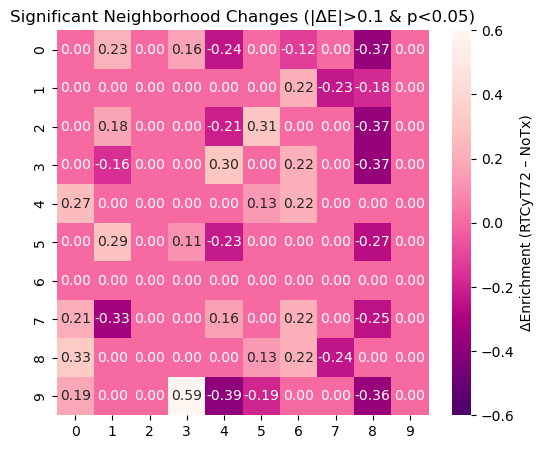

In [49]:
import numpy as np

# Suppose you want only |ΔE|>0.1 AND p<0.05
deltaE = ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]["NoTx_RTCyT72"]["enrichment"]
pmat   = ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]["NoTx_RTCyT72"]["pvalue"]

mask = (np.abs(deltaE) > 0.1) & (pmat < 0.05)
# Create a masked array so that “non-significant” cells become white
display_matrix = deltaE.where(mask, other=0.0)

# Then plot display_matrix with seaborn or matplotlib, using the same colormap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(
    display_matrix,
    cmap="RdPu_r",                # or whichever diverging map you prefer
    vmin=-0.6, vmax=+0.6,         # fix your color limits to match all conditions
    annot=True, fmt=".2f",        # optional: print numbers
    cbar_kws={"label":"ΔEnrichment (RTCyT72 – NoTx)"}
)
plt.title("Significant Neighborhood Changes (|ΔE|>0.1 & p<0.05)")


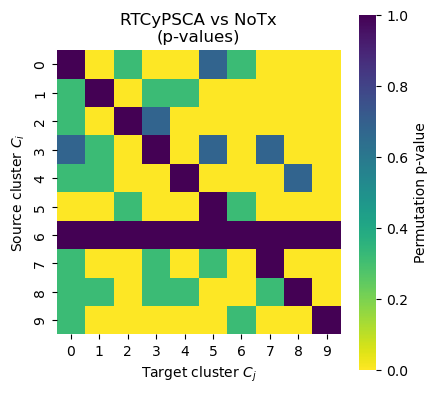

In [29]:
# 1) List all available keys
# list( ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"].keys() )
# e.g. ['RTCyT72_NoTx', 'RTCyPSCA_NoTx', 'CyPSCA_NoTx', 'CyT72_NoTx', … plus their reversals …]
# ['NoTx_RTCyT72',
#  'NoTx_RTCyPSCA',
#  'NoTx_CyPSCA',
#  'NoTx_CyT72',
#  'RTCyT72_RTCyPSCA',
#  'RTCyT72_CyPSCA',
#  'RTCyT72_CyT72',
#  'RTCyPSCA_CyPSCA',
#  'RTCyPSCA_CyT72',
#  'CyPSCA_CyT72']

# 1) List the four comparisons you care about. These must match exactly the keys 
#    that appear under ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"].
#    In your case, those keys are named "NoTx_RTCyT72", "NoTx_RTCyPSCA", "NoTx_CyPSCA", "NoTx_CyT72".
comparisons = [
    # "NoTx_RTCyT72",
    "NoTx_RTCyPSCA"#,
    # "NoTx_CyPSCA",
    # "NoTx_CyT72"
]

# 2) Pull out the diff_nhood_enrichment dictionary:
diff_dict = ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]

# 3) Figure out the cluster ordering used by CellCharter,
#    so that our rows/columns line up with the ΔE plots exactly.
clusters = ST_sample.obs["cluster_cellcharter"].cat.categories.tolist()

# 4) Build a list of p-value DataFrames, in the same order as `comparisons`.
pval_matrices = []
for key in comparisons:
    if key not in diff_dict:
        raise KeyError(f"Could not find key '{key}' under diff_nhood_enrichment; available keys are:\n{list(diff_dict.keys())}")
    # Each entry (diff_dict[key]) is a dict with keys "enrichment" and "pvalues".
    pvals_df = diff_dict[key]["pvalue"].copy()
    # Reindex so that rows + columns follow the same cluster order
    pvals_df = pvals_df.reindex(index=clusters, columns=clusters)
    pval_matrices.append(pvals_df)

# 5) Plot them side by side in a 1×4 grid (or whatever layout you like).
n = len(comparisons)
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4*ncols, 4*nrows),
    tight_layout=True
)

# If there is only one row, ensure `axes` is 2D so we can index it as [row,col].
if nrows == 1:
    axes = np.array(axes).reshape(1, -1)

for idx, key in enumerate(comparisons):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]
    
    # Plot the p-value heatmap
    sns.heatmap(
        pval_matrices[idx],
        vmin=0.0, vmax=1.0,
        cmap="viridis_r",    # low p‐values = dark purple; high p‐values = light yellow
        square=True,
        cbar_kws={"label": "Permutation p-value"},
        ax=ax
    )
    # Make a title like “RTCyT72 vs NoTx (p-values)” from the key “NoTx_RTCyT72”
    # If you’d rather see “RTCyT72 vs NoTx” instead of “NoTx vs RTCyT72”, you can swap the pieces:
    cond1, cond2 = key.split("_")
    ax.set_title(f"{cond2} vs {cond1}\n(p-values)")
    ax.set_xlabel("Target cluster $C_j$")
    ax.set_ylabel("Source cluster $C_i$")

# If there are any “extra” subplots in the grid, delete them:
total_plots = nrows * ncols
for extra_idx in range(n, total_plots):
    r = extra_idx // ncols
    c = extra_idx % ncols
    fig.delaxes(axes[r, c])

plt.show()


In [28]:
pvals_df

,0,1,2,3,4,5,6,7,8,9
0,1.00,0.00,0.52,0.00,0.00,0.52,0.00,0.48,0.00,0.48
1,0.48,1.00,0.00,0.48,0.52,0.48,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.52,0.00,0.00,0.00,0.00,0.00,0.52
3,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.52,0.00,0.00,1.00,0.00,0.00,0.00,0.48,0.52
5,0.48,0.00,0.00,0.00,0.00,1.00,0.52,0.52,0.00,0.48
6,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,0.52,0.00,0.00,0.52,0.00,0.48,0.00,1.00,0.00,0.00
8,0.00,0.48,0.00,0.52,0.52,0.00,0.00,0.00,1.00,0.52
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


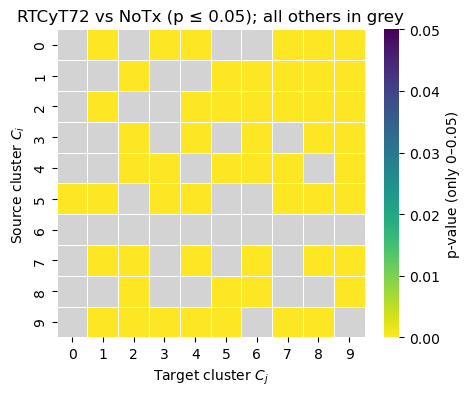

In [30]:
# Suppose `pvals_df` is your (cluster × cluster) DataFrame of p-values,
# indexed and columned by the same “clusters” list we used before.

# 1) Make a masked copy where any p > 0.05 becomes NaN
masked_p = pvals_df.copy()
masked_p[masked_p > 0.05] = np.nan

# 2) Grab the reversed-viridis colormap and tell it to paint NaNs as lightgrey
cmap = plt.cm.viridis_r  # reversed viridis
cmap.set_bad(color="lightgrey")

# 3) Plot with seaborn, using mask=masked_p.isna() so that seaborn knows where those NaNs live
plt.figure(figsize=(5, 4))
sns.heatmap(
    masked_p,
    cmap=cmap,
    vmin=0.0, vmax=0.05,           # restrict color‐scaling to [0, 0.05]
    mask=masked_p.isna(),         # draw NaNs as “bad” (i.e. grey)
    square=True,
    cbar_kws={"label": "p-value (only 0–0.05)"},
    linewidths=0.5,
    linecolor="white"
)
plt.title("RTCyT72 vs NoTx (p ≤ 0.05); all others in grey")
plt.xlabel("Target cluster $C_j$")
plt.ylabel("Source cluster $C_i$")
plt.show()


# Saving file

In [108]:
ST_sample

AnnData object with n_obs × n_vars = 169773 × 16794
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mouse', 'sample_id', 'condition', 'cx', 'cy', 'TMA', 'library_id', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter'
    var: 'n_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_colors', 'condition_colors', 'log1p', 'spatial', 'spatial_neighbors', 'rank_genes', 'cluster_cellcharter_condition_diff_nhood_enrichment', 'rank_0', 'shape_cluster_cellcharter'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [107]:
ST_sample.obsm['spatial'].shape

(169773, 2)

In [111]:
def summarize_anndata(adata):
    report = []

    report.append(f"AnnData object with shape: {adata.shape}\n")

    report.append("OBSERVATIONS (.obs):")
    report.append(f"  Columns: {list(adata.obs.columns)}\n")

    report.append("VARIABLES (.var):")
    report.append(f"  Columns: {list(adata.var.columns)}\n")

    report.append("OBS MATRICES (.obsm):")
    for k in adata.obsm.keys():
        report.append(f"  {k}: shape {adata.obsm[k].shape}")

    report.append("\nOBS PAIRWISE (.obsp):")
    for k in adata.obsp.keys():
        report.append(f"  {k}: shape {adata.obsp[k].shape}")

    report.append("\nLAYERS:")
    for k in adata.layers.keys():
        report.append(f"  {k}: shape {adata.layers[k].shape}")

    report.append("\nUNSTRUCTURED (.uns):")
    for k in adata.uns_keys():
        item = adata.uns[k]
        if isinstance(item, dict):
            report.append(f"  {k}: dict with keys {list(item.keys())}")
        elif hasattr(item, 'shape'):
            report.append(f"  {k}: array-like, shape {item.shape}")
        else:
            report.append(f"  {k}: type {type(item)}")

    return "\n".join(report)

print(summarize_anndata(ST_sample))


AnnData object with shape: (169773, 16794)

OBSERVATIONS (.obs):
  Columns: ['id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mouse', 'sample_id', 'condition', 'cx', 'cy', 'TMA', 'library_id', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter']

VARIABLES (.var):
  Columns: ['n_counts']

OBS MATRICES (.obsm):
  X_cellcharter: shape (169773, 20)
  X_scVI: shape (169773, 10)
  spatial: shape (169773, 2)

OBS PAIRWISE (.obsp):
  spatial_connectivities: shape (169773, 169773)
  spatial_distances: shape (169773, 169773)

LAYERS:
  counts: shape (169773, 16794)

UNSTRUCTURED (.uns):
  _scvi_manager_uuid: type <class 'str'>
  _scvi_uuid: type <class 'str'>
  cluster_cellcharter_colors: array-like, shape (10,)
  cluster_cellcharter_condition_diff_nhood_enrichment: dict with keys ['NoTx_RTCyT72', 'NoTx_RTCyPSCA', 'No

In [112]:
ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]

{'NoTx_RTCyT72': {'enrichment':           0         1         2         3         4         5         6  \
  0       NaN  0.228322 -0.006618  0.159566 -0.241232  0.012337 -0.119227   
  1  0.097425       NaN  0.012267 -0.004470 -0.035166  0.007273  0.215893   
  2  0.056526  0.176645       NaN  0.020284 -0.212366  0.311247 -0.125396   
  3  0.052119 -0.164254  0.019248       NaN  0.301001  0.042407  0.219913   
  4  0.265959 -0.240317  0.020463  0.098723       NaN  0.131774  0.220310   
  5 -0.026768  0.290181  0.002293  0.114087 -0.226441       NaN  0.061732   
  6       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
  7  0.209246 -0.331082  0.007075 -0.019049  0.156958 -0.013648  0.217650   
  8  0.331801 -0.237186  0.020051 -0.031093  0.145298  0.132549  0.220310   
  9  0.187062 -0.054478  0.017980  0.586328 -0.387743 -0.194982  0.143706   
  
            7         8         9  
  0  0.001955 -0.372276  0.005373  
  1 -0.230237 -0.179993 -0.017517  
  2  0.09552

In [113]:
diff = ST_sample.uns["cluster_cellcharter_condition_diff_nhood_enrichment"]

for comp, comp_dict in diff.items():
    for mat in ("enrichment", "pvalue"):
        df = comp_dict[mat]
        # make row & column names strings
        df.index = df.index.astype(str)
        df.columns = df.columns.astype(str)

In [115]:
del ST_sample.uns["shape_cluster_cellcharter"]

In [117]:
ST_sample.write("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/onefer_enriched.h5ad")

# Gene-level and pathway analysis

In [ ]:
import scanpy as sc

# 1) Run DE test for all clusters (one‐vs‐all)
sc.tl.rank_genes_groups(
    ST_sample,
    groupby="cluster_cellcharter",
    method="wilcoxon",
    n_genes=ST_sample.shape[1],  # test every gene
    key_added="rank_genes"
)

# 2) Extract the top 20 genes per cluster into a dictionary
top20_per_cluster = {}
for cluster in ST_sample.obs["cluster_cellcharter"].cat.categories:
    # cluster might be an integer (0,1,2…), so convert to string:
    cluster_str = str(cluster)
    df = sc.get.rank_genes_groups_df(ST_sample, group=cluster_str, key="rank_genes")
    # Sort by descending log‐fold‐change and take top 20
    df_sorted = df.sort_values("logfoldchanges", ascending=False)
    top20_per_cluster[cluster_str] = df_sorted["names"].tolist()[:20]

In [61]:
# 3) Print results
for cluster_str, genes in top20_per_cluster.items():
    print(f"\nCluster {cluster_str}:")
    print(", ".join(genes[0:10]))


Cluster 0:
Rdh16, Catsper3, Sfrp5, Rnf186, Apoe, Tcp10b, AY358078, Hs3st5, Kcns2, BC107364

Cluster 1:
Nlrp4e, Slc26a4, Vpreb3, CN725425, Htr4, Btnl4, Dcdc2a, Cyp7a1, Mmp21, Fbxo39

Cluster 2:
Crnn, Krt82, Crym, Krt35, Krt73, Krt75, Krt72, Dsg4, Dsg1a, Ovol1

Cluster 3:
Wdr95, Sprr2d, Olfr262, Krt24, Dnah5, Olfr250, Gabra4, Bend7, Ttll6, Chrna6

Cluster 4:
Olfr726, Vmn1r46, Olfr597, Shank1, Stmn3, mt-Cytb, mt-Co2, mt-Atp8, mt-Atp6, Olfr1134

Cluster 5:
Hspb9, H2-Q2, Scgb3a1, Vmn2r60, Abca13, H2-M1, Sptssb, Olfr594, Trbv21, Tas2r113

Cluster 6:
Egfl6, Col9a2, Sox10, Arhgef16, Col1a2, Col1a1, Col3a1, Tnmd, Pdzrn4, Apoe

Cluster 7:
Glt6d1, Vmn1r185, Rec8, ETV3L, Slc6a16, Olfr965, Pcsk1n, Olfr769, Mkrn2os, V1rd19

Cluster 8:
Btnl10, Acan, Ero1l, Egln3, Mt2, Mt1, Scd3, Slc22a19, Slc2a1, Csf3

Cluster 9:
Efcab1, Fev, Gpr50, Olfr1449, Aqp7, Gadl1, Olfr1491, Gbp2, Scgb1a1, Slc5a1


In [60]:
top20_per_cluster

{'0': ['Rdh16',
  'Catsper3',
  'Sfrp5',
  'Rnf186',
  'Apoe',
  'Tcp10b',
  'AY358078',
  'Hs3st5',
  'Kcns2',
  'BC107364',
  'Cadps',
  'Rad51ap2',
  'Sdk2',
  'Lipo4',
  'Lrrtm4',
  'Olfr1434',
  'Rnf148',
  'Amer2',
  'Olfr593',
  'Gpr139'],
 '1': ['Nlrp4e',
  'Slc26a4',
  'Vpreb3',
  'CN725425',
  'Htr4',
  'Btnl4',
  'Dcdc2a',
  'Cyp7a1',
  'Mmp21',
  'Fbxo39',
  'Ostn',
  'Olfr399',
  'Nek5',
  'Gkn2',
  'Il1rapl1',
  'Gdf7',
  'Prlh',
  'Vmn1r86',
  'Olfr1204',
  'Nrsn2'],
 '2': ['Crnn',
  'Krt82',
  'Crym',
  'Krt35',
  'Krt73',
  'Krt75',
  'Krt72',
  'Dsg4',
  'Dsg1a',
  'Ovol1',
  'Krt28',
  'Krtap8-1',
  'Calml3',
  'Ckmt1',
  'Kbtbd12',
  'Krt5',
  'Krt25',
  'Calhm4',
  'Smtnl1',
  'Lrrn1'],
 '3': ['Wdr95',
  'Sprr2d',
  'Olfr262',
  'Krt24',
  'Dnah5',
  'Olfr250',
  'Gabra4',
  'Bend7',
  'Ttll6',
  'Chrna6',
  'Krtap5-2',
  'Olfr550',
  'Cmtm2b',
  'Pcare',
  'Atp6v1e2',
  'BC030500',
  'Olfr1436',
  'Spata9',
  'Krtap6-3',
  'Gjc3'],
 '4': ['Olfr726',
  'Vmn1r46',
 

In [62]:
out_EA = base_folder / "figures" / "enrichment_analysis"

In [63]:
out_EA

PosixPath('/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/enrichment_analysis')

In [70]:
for mouse in ST_sample.obs['mouse'].unique():
    print(mouse)

RTCyT72_2_1
RTCyPSCA_1_4
CyPSCA_1_1
NoTx_2_2
CyPSCA_1_2
RTCyT72_2_4
RTCyPSCA_2_4
CyT72_1_4


In [67]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp
from pathlib import Path

# ─── Step 0: Define output directory ────────────────────────────────────────────
# (Assumes you have already set `base_folder` somewhere above)
out_EA = base_folder / "figures" / "enrichment_analysis"
out_EA.mkdir(parents=True, exist_ok=True)

# ─── Step 1: Run DE test (one‐vs‐all) for every gene in each cluster ─────────────
sc.tl.rank_genes_groups(
    ST_sample,
    groupby="cluster_cellcharter",
    method="wilcoxon",
    n_genes=ST_sample.shape[1],  # test every gene
    key_added="rank_genes"
)

# ─── Parameters for Enrichment ─────────────────────────────────────────────────
n_pathways = 20
gene_sets = ["GO_Biological_Process_2021"]
organism = "Mouse"  # adjust if necessary

# ─── Step 2 & 3: For each cluster, extract all significant genes (adj p < 0.05)
#                and run Enrichr, then plot+save top n_pathways ─────────────────
for cluster in ST_sample.obs["cluster_cellcharter"].cat.categories:
    cluster_str = str(cluster)
    # 2a) Get DE results for this cluster
    df = sc.get.rank_genes_groups_df(
        ST_sample,
        group=cluster_str,
        key="rank_genes"
    )
    # 2b) Filter by adjusted p‐value < 0.05 (you can adjust threshold as needed)
    sig_df = df[df["pvals_adj"] < 0.05]
    gene_list = sig_df["names"].tolist()
    if len(gene_list) == 0:
        # Skip if no genes pass the threshold
        print(f"No significant genes (adj p < 0.05) found for cluster {cluster_str}. Skipping enrichment.")
        continue

    # 3a) Run Enrichr
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets=gene_sets,
        organism=organism,
        outdir=None  # don’t write any files to disk automatically
    )

    # 3b) Pull results, sort by adjusted p‐value, take top n_pathways
    res = enr.results.sort_values("Adjusted P-value").head(n_pathways)
    if res.shape[0] == 0:
        print(f"No pathways returned for cluster {cluster_str}.")
        continue

    # 3c) Compute Gene_Ratio and –log10(adj p)
    res["Gene_Ratio"] = res["Overlap"].apply(
        lambda x: int(x.split("/")[0]) / int(x.split("/")[1])
    )
    res["neg_log10_padj"] = -np.log10(res["Adjusted P-value"])

    # 3d) Sort by neg_log10_padj ascending for plotting
    res_plot = res.sort_values("neg_log10_padj", ascending=True)

    # 3e) Create scatter plot
    fig, ax = plt.subplots(figsize=(10, n_pathways * 0.4))
    sc_plot = ax.scatter(
        res_plot["Gene_Ratio"],
        res_plot["Term"],
        s=res_plot["neg_log10_padj"] * 50,
        c=res_plot["neg_log10_padj"],
        cmap="viridis"
    )
    ax.set_xlabel("Gene Ratio")
    ax.set_ylabel("")  # Terms are on the y‐axis
    ax.set_title(f"Top {n_pathways} Enriched Pathways for Cluster {cluster_str}")
    cbar = plt.colorbar(sc_plot, ax=ax)
    cbar.set_label("-log10(Adjusted P-value)")

    plt.tight_layout()
    # 3f) Save figure
    out_file = out_EA / f"cluster_{cluster_str}_enrichment.png"
    fig.savefig(out_file, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved enrichment plot for cluster {cluster_str}: {out_file}")


Saved enrichment plot for cluster 0: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/enrichment_analysis/cluster_0_enrichment.png
Saved enrichment plot for cluster 1: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/enrichment_analysis/cluster_1_enrichment.png
Saved enrichment plot for cluster 2: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/enrichment_analysis/cluster_2_enrichment.png
Saved enrichment plot for cluster 3: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/enrichment_analysis/cluster_3_enrichment.png
Saved enrichment plot for cluster 4: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/enrichment_analysis/cluster_4_enrichment.png
Saved enrichment plot for cluster 5: /mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/onefer/figures/e

# Communications

In [9]:
help(sp.gr.ligrec)
# use mouseconcensus

Help on function ligrec in module squidpy.gr._ligrec:

ligrec(adata: 'AnnData | SpatialData', cluster_key: 'str', interactions: 'Interaction_t | None' = None, complex_policy: "Literal['min', 'all']" = 'min', threshold: 'float' = 0.01, corr_method: 'str | None' = None, corr_axis: "Literal['interactions', 'clusters']" = 'clusters', use_raw: 'bool' = True, copy: 'bool' = False, key_added: 'str | None' = None, gene_symbols: 'str | None' = None, **kwargs: 'Any') -> 'Mapping[str, pd.DataFrame] | None'
    Perform the permutation test as described in :cite:`cellphonedb`.
    
    Parameters
    ----------
    adata
        Annotated data object.
    use_raw
        Whether to access :attr:`anndata.AnnData.raw`.
    interactions
        Interaction to test. The type can be one of:
    
            - :class:`pandas.DataFrame` - must contain at least 2 columns named `'source'` and `'target'`.
            - :class:`dict` - dictionary with at least 2 keys named `'source'` and `'target'`.
         

In [1]:
import liana as li
# LIANA wraps several community-standard methods (CellPhoneDB, NATMI, Connectome, CellChat etc.) and gives you a unified results table.
# Tutorial link: https://liana-py.readthedocs.io/en/latest/notebooks/prior_knowledge.html
from pypath import omnipath as op
import decoupler as dc

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
# 1) Subset to your sample and clusters
adata = ST_sample[ST_sample.obs['mouse']=="RTCyPSCA_1_4"].copy()

# Ensure raw counts are stored
adata.layers["counts"] = adata.layers.get("counts", adata.X.copy())

In [5]:
# show available resources to confirm “mouseconsensus” is there
print(li.resource.show_resources())
# […] includes 'mouseconsensus' among others

lr_df = li.pp.liana(
    adata,
    resource="mouseconsensus",   # uses mouse ligand–receptor pairs directly
    organism=None,               # skip any additional orthology step
    layer_counts="counts",       # raw counts layer for any DE steps
    n_perms=0                    # no permutations → just scores
)

['baccin2019', 'cellcall', 'cellchatdb', 'cellinker', 'cellphonedb', 'celltalkdb', 'connectomedb2020', 'consensus', 'embrace', 'guide2pharma', 'hpmr', 'icellnet', 'italk', 'kirouac2010', 'lrdb', 'mouseconsensus', 'ramilowski2015']


AttributeError: module 'liana' has no attribute 'pp'

In [ ]:
# Filter for cluster 1 → cluster 7 communications
comm_1_7 = (
    lr_df
    .query("source == '1' and target == '7'")
    .sort_values("magnitude", ascending=False)   # or by pvalue if you ran perms
)

# Inspect top candidates
print(comm_1_7.head(10))

# Cluster Shapes

In [ ]:
# Calculating boundaries

In [25]:
cc.gr.connected_components(
    ST_sample,
    cluster_key="cluster_cellcharter",
    connectivity_key="spatial", # Again it adds "_connectivities" for some reason
    min_cells=50,
    out_key='component', # this is default, but I'm adding it to know the names
    copy=False
)


#   • ST_sample.obs["component"]  exists (one integer per cell).
#   • ST_sample.uns["shape_cluster_cellcharter"]["boundary"]  holds each component’s Polygon.

cc.tl.boundaries(
    ST_sample,
    cluster_key='cluster_cellcharter',
)

In [26]:
cc.tl.curl(
    ST_sample,
    cluster_key='cluster_cellcharter',
    copy=False
)
cc.tl.linearity(
    ST_sample,
    cluster_key='cluster_cellcharter',
    copy=False
)
cc.tl.elongation(
    ST_sample,
    cluster_key='cluster_cellcharter',
    copy=False
)

cc.tl.purity(
    ST_sample,
    cluster_key='cluster_cellcharter',
    library_key='mouse',
    copy=False
)

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/cellcharter/tl/_shape.py:429: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample = adata[adata.obs[cluster_key] == cluster].obs[library_key][0]


In [87]:
ST_sample.obs['mouse'].unique()

['RTCyT72_2_1', 'RTCyPSCA_1_4', 'CyPSCA_1_1', 'NoTx_2_2', 'CyPSCA_1_2', 'RTCyT72_2_4', 'RTCyPSCA_2_4', 'CyT72_1_4']
Categories (8, object): ['CyPSCA_1_1', 'CyPSCA_1_2', 'CyT72_1_4', 'NoTx_2_2', 'RTCyPSCA_1_4', 'RTCyPSCA_2_4', 'RTCyT72_2_1', 'RTCyT72_2_4']

In [20]:
subset = ST_sample[ST_sample.obs["mouse"].isin(["RTCyPSCA_1_4", "NoTx_2_2"])]
print("Subset shape:", subset.shape)
print("cluster_cellcharter column exists:", "cluster_cellcharter" in subset.obs.columns)
print("Missing cluster labels:", subset.obs["cluster_cellcharter"].isna().sum())
print("Cluster value counts:\n", subset.obs["cluster_cellcharter"].value_counts())


Subset shape: (48922, 16794)
cluster_cellcharter column exists: True
Missing cluster labels: 0
Cluster value counts:
 cluster_cellcharter
4    18709
8    13549
6     3638
9     3629
7     3331
1     2230
3     2152
5     1229
2      398
0       57
Name: count, dtype: int64


/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


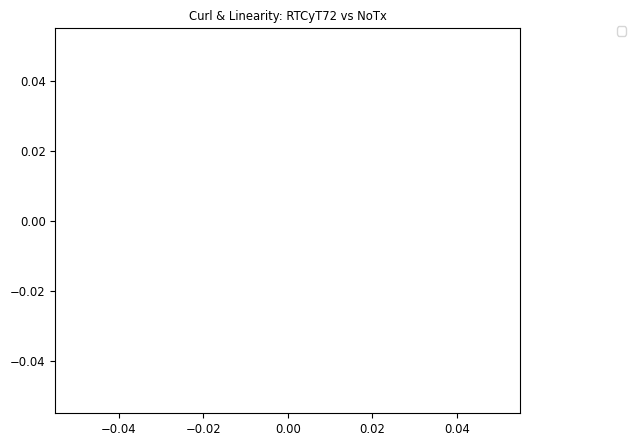

In [27]:
ST_sample.obs["_dummy_cluster_key"] = ST_sample.obs["cluster_cellcharter"]

cc.pl.shape_metrics(
    ST_sample,
    condition_key="mouse",
    condition_groups=["RTCyPSCA_1_4", "NoTx_2_2"],
    component_key="cluster_cellcharter",
    cluster_key="_dummy_cluster_key",  # avoids the duplicate-column crash
    metrics=("curl", "linearity"),
    figsize=(6, 5),
    title="Curl & Linearity: RTCyT72 vs NoTx"
)


In [79]:
ST_sample.uns["shape_cluster_cellcharter"]["boundary"]

{2: <POLYGON ((7210.102 1841.583, 6732.021 2088.903, 6600.18 2344.516, 6486.354 ...>,
 5: <POLYGON ((1046.475 8822.287, 925.731 9976.707, 1617.644 11209.452, 1867.795...>,
 7: <POLYGON ((1259.265 10988.634, 1526.803 11457.093, 1587.556 11549.046, 1900....>,
 1: <POLYGON ((2991.42 1805.582, 2704.835 1825.326, 2125.66 1826.373, 2079.889 1...>,
 9: <POLYGON ((3589.7 12051.724, 3846.248 12266.327, 4259.54 12367.857, 4645.627...>,
 4: <POLYGON ((3619.671 2103.803, 2047.705 3397.773, 838.172 3694.903, 891.101 4...>,
 0: <POLYGON ((1441 10521.721, 2238.113 11480.208, 3804.951 12512.835, 3852.436 ...>,
 6: <POLYGON ((918.3 5439.528, 991.35 5539.161, 1101.896 5660.743, 1131.946 5682...>,
 3: <POLYGON ((805.287 7841.55, 809.424 7891.211, 849.303 8591.498, 828.035 8728...>,
 8: <POLYGON ((952.095 9701.78, 1068.4 10336.451, 1107.03 10620.092, 1158.243 10...>}

In [93]:
cc.tl.boundaries(ST_sample, cluster_key="cluster_cellcharter")

In [94]:
cc.pl.boundaries(
    ST_sample,
    sample='CyPSCA_1_1',
    library_key='mouse',
    component_key='cluster_cellcharter',
    show_cells=False
)

ValueError: scipy.sparse does not support dtype object. The only supported types are: bool_, int8, uint8, int16, uint16, int32, uint32, int64, uint64, longlong, ulonglong, float32, float64, longdouble, complex64, complex128, clongdouble.

In [95]:
import cellcharter.pl._shape as ccshape
import cellcharter.pl as ccpl
import anndata as ad
import numpy as np
import geopandas
import matplotlib.pyplot as plt

def safe_boundaries(adata, sample, library_key, component_key, alpha_boundary=0.05, show_cells=True, save=None):
    adata = adata[adata.obs[library_key] == sample].copy()
    del adata.raw
    clusters = adata.obs[component_key].unique()

    # Pull only boundaries for visible clusters
    boundaries = {
        cluster: boundary
        for cluster, boundary in adata.uns[f"shape_{component_key}"]["boundary"].items()
        if cluster in clusters
    }

    gdf = geopandas.GeoDataFrame(geometry=list(boundaries.values()), index=np.arange(len(boundaries)).astype(str))

    # Skips problem if we don’t need cell plotting
    if not show_cells:
        gdf.plot(facecolor="none", edgecolor="black", linewidth=1)
        plt.axis("equal")
        if save:
            plt.savefig(save, dpi=300)
        plt.show()
        return

    # Otherwise, fallback to the original method
    ccshape.boundaries(
        adata, sample=sample, library_key=library_key, component_key=component_key,
        alpha_boundary=alpha_boundary, show_cells=True, save=save
    )

# Override the broken one
ccpl.boundaries = safe_boundaries


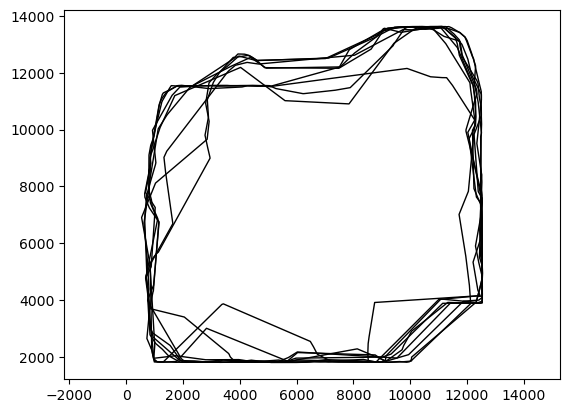

In [96]:
cc.pl.boundaries(
    ST_sample,
    sample='CyPSCA_1_1',
    library_key='mouse',
    component_key='cluster_cellcharter',
    show_cells=False
)


In [65]:
ST_sample.obs["instance_id"] = ST_sample.obs_names

In [58]:
ST_sample.obs.columns

Index(['id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'mouse', 'sample_id', 'condition', 'cx',
       'cy', 'TMA', 'library_id', 'n_counts', '_scvi_batch', '_scvi_labels',
       'cluster_cellcharter'],
      dtype='object')

In [76]:
ST_sample.obsp

PairwiseArrays with keys: spatial_connectivities, spatial_distances

In [92]:
cc.pl.boundaries(
    ST_sample,
    sample='CyPSCA_1_1',
    library_key='mouse',
    component_key='cluster_cellcharter',
    show_cells=False
)


KeyError: 'shape_cluster_cellcharter'

In [67]:
subset = ST_sample[ST_sample.obs["sample_id"] == "CyPSCA_1_1"]

# 1. Confirm there are actually cells
print("Number of observations:", subset.n_obs)

# 2. Check if spatial coordinates exist
print("obsm keys:", subset.obsm.keys())

# 3. Print spatial shape and first few rows
if "spatial" in subset.obsm:
    spatial = subset.obsm["spatial"]
    print("Spatial shape:", spatial.shape)
    print("Any NaNs in spatial:", np.isnan(spatial).any())
    print("First few coordinates:\n", spatial[:5])
else:
    print("No 'spatial' in obsm")


Number of observations: 0
obsm keys: KeysView(AxisArraysView with keys: X_cellcharter, X_scVI, spatial)
Spatial shape: (0, 2)
Any NaNs in spatial: False
First few coordinates:
 []


In [54]:
# Compute component labels + shape metrics

cc.tl.curl(ST_sample,
          cluster_key='cluster_cellcharter',
          out_key='curl')

KeyError: 'shape_cluster_cellcharter'

## debuging

In [81]:
adata_dummy = ad.AnnData(X=np.array([['polygon1'], ['polygon2']], dtype=object))

In [89]:
adata_dummy.obs["region"]=["clusters", "cells"]

In [90]:
adata_dummy.obs['instance_id'] = ['0', '1']

In [91]:
ad.concat((ST_sample, adata_dummy))

ValueError: scipy.sparse does not support dtype object. The only supported types are: bool_, int8, uint8, int16, uint16, int32, uint32, int64, uint64, longlong, ulonglong, float32, float64, longdouble, complex64, complex128, clongdouble.